In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

## General definitions

In [2]:
hubble = 0.697
BoxSize = 64.0

In [3]:
def load_rockstar_data(rockstar_name, boxsize=64.0):
    dtype=[
        ('ID' ,'i8'),('DescID' ,'i8'),('Mvir','f8'),('Vmax','f8'),('Vrms','f8'),('Rvir','f8'),('Rs','f8'),( 'Np','i8'),
        ( 'X','f8'),( 'Y','f8'),( 'Z','f8'),( 'VX','f8'),( 'VY','f8'),( 'VZ','f8'),
        ( 'JX','f8'),( 'JY','f8'),( 'JZ','f8'),( 'Spin','f8'),( 'rs_klypin' ,'f8'),('Mvir_all' ,'f8'),('M200b','f8'),
        ( 'M200c','f8'),( 'M500c','f8'),( 'M2500c' ,'f8'),('Xoff','f8'),( 'Voff','f8'),( 'spin_bullock','f8'),
        ( 'b_to_a','f8'),( 'c_to_a','f8'),( 'A[x]' ,'f8'),('A[y]','f8'),('A[z]','f8'),
        ( 'b_to_a(500c)' ,'f8'),('c_to_a(500c)' ,'f8'),('A[x](500c)','f8'),( 'A[y](500c)' ,'f8'),
        ('A[z](500c)' ,'f8'),('T_U','f8'),( 'M_pe_Behroozi','f8'),( 'M_pe_Diemer','f8'),('Halfmass_Radius','f8'), 
        ('PID', 'i8')]
    snap_data = np.loadtxt(rockstar_name, dtype=dtype)    
   
    return snap_data

In [4]:
gr_full_data = load_rockstar_data('../data/halos/GR/out_0.list')
fr_full_data = load_rockstar_data('../data/halos/FR6/out_0.list')

In [5]:
ii = (gr_full_data['Mvir']/hubble > 21E11) #& (gr_full_data['PID']==-1)
gr_data = gr_full_data[ii]
ii = (fr_full_data['Mvir']/hubble > 21E11)# & (fr_full_data['PID']==-1)
fr_data = fr_full_data[ii]
print(len(gr_data))

754


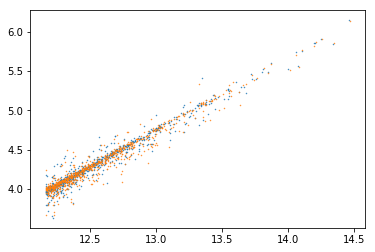

In [6]:
plt.scatter(np.log10(gr_data['Mvir']), np.log10(gr_data['Np']), s=0.2)
plt.scatter(np.log10(fr_data['Mvir']), np.log10(fr_data['Np']), s=0.2)

In [7]:
def find_LG_pairs(in_data):
    #pad boxes to mimic periodic boundary conditions
    new_data = in_data.copy()
    n = len(new_data)
    pos = np.ones([n,3])
    vel = np.ones([n,3])
    for i,j in zip([0,1,2], ['X','Y','Z']):
        pos[:,i] = new_data[j].copy()
        vel[:,i] = new_data['V'+j].copy()
    vmax = new_data['Vmax'].copy()
    mvir = new_data['Mvir'].copy()
    haloid = np.arange(n)

    pad_pos = pos.copy()
    pad_vel = vel.copy()
    pad_vmax = vmax.copy()
    pad_mvir = mvir.copy()
    pad_haloid = haloid.copy()

    for i in (0,1,-1):
        for j in (0,1,-1):
            for k in (0,1,-1):
                new_pos = pos.copy()
                if(i):
                    new_pos[:,0] = new_pos[:,0] + i*BoxSize
                if(j):
                    new_pos[:,1] = new_pos[:,1] + j*BoxSize
                if(k):
                    new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
                if((i!=0) | (j!=0) | (k!=0)):
                    pad_pos = np.append(pad_pos, new_pos, axis=0)
                    pad_vel = np.append(pad_vel, vel, axis=0)
                    pad_vmax = np.append(pad_vmax, vmax)
                    pad_mvir = np.append(pad_mvir, mvir)
                    pad_haloid = np.append(pad_haloid, np.arange(n))

    

    #find neighbors
    nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(pad_pos)
    dist, ind = nbrs.kneighbors(pad_pos)
    print(pad_pos.shape)
    print(dist.shape)
    
    neighbor_index = ind[:,1]
    neighbor_list = ind[:,2:]
    print(np.shape(neighbor_list))

    #define pairs
    n_pairs = 0

    halo_A_id = np.empty((0), dtype=int)
    halo_B_id = np.empty((0), dtype=int)
    for i in range(n):
        j = neighbor_index[i] % n # nearest neighbor of i
        l = neighbor_index[neighbor_index[i]]% n # nearest neighbor of j
    
        other_j = neighbor_list[i,:] % n # all neightbors of i.
        other_l = neighbor_list[neighbor_index[i],:] % n # all neightbors of i-th's neighbors
        if(i==l):# reciprocity principle
            virial_radius_i = fr_data['Rvir'][i]
            virial_radius_l = fr_data['Rvir'][l]
            if(dist[i,1]<(virial_radius_i + virial_radius_l)): # Check that the halos are not merging
                if((not (j in halo_A_id)) & (not (i in halo_B_id))): # don't add pairs that are already in the list # check the IDS might be a bug
                    vmax_i = pad_vmax[i]
                    vmax_j = pad_vmax[j]
                    vmax_limit = min([vmax_i, vmax_j])
                    #vmax_limit = 
                    #dist_limit = max(3.0*hubble, 4.0*dist[i,1])
                    dist_limit = 2.5*hubble
#                    massive_close_to_i = any((dist[i,2:]<dist_limit) & (pad_vmax[other_j]>=vmax_limit))
#                    massive_close_to_j = any((dist[j,2:]<dist_limit) & (pad_vmax[other_l]>=vmax_limit))
                    massive_close_to_i = any((dist[i,2:]<dist_limit))
                    massive_close_to_j = any((dist[j,2:]<dist_limit))
                    if((not massive_close_to_i) & (not massive_close_to_j)): 
                        n_pairs = n_pairs + 1
                        halo_A_id = np.append(halo_A_id, int(i))
                        halo_B_id = np.append(halo_B_id, int(j))
    return halo_A_id, halo_B_id, \
    pad_vmax[halo_A_id], pad_vmax[neighbor_index[halo_A_id]],\
    pad_mvir[halo_A_id], pad_mvir[neighbor_index[halo_A_id]],\
    pad_pos[halo_A_id,:], pad_pos[neighbor_index[halo_A_id], :],\
        pad_vel[halo_A_id,:], pad_vel[neighbor_index[halo_A_id], :]

## Build the sample of Isolated Pairs

In [8]:
halo_A_GR, halo_B_GR, vmax_A_GR, vmax_B_GR, mvir_A_GR, mvir_B_GR, pos_A_GR, pos_B_GR, vel_A_GR, vel_B_GR = find_LG_pairs(gr_data)
halo_A_FR, halo_B_FR, vmax_A_FR, vmax_B_FR, mvir_A_FR, mvir_B_FR, pos_A_FR, pos_B_FR, vel_A_FR, vel_B_FR = find_LG_pairs(fr_data)

(20358, 3)
(20358, 20)
(20358, 18)
(21627, 3)
(21627, 20)
(21627, 18)


In [9]:
# Number of isolated pairs
print('FR', len(halo_A_FR))
print('GR', len(halo_A_GR))

FR 167
GR 156


## Compute kinematic conditions for the isolated pairs

In [10]:
relative_pos_GR = pos_B_GR - pos_A_GR
relative_vel_GR = vel_B_GR - vel_A_GR
norm_relative_vel_GR = np.sqrt((relative_vel_GR**2).sum(1))
norm_relative_pos_GR = np.sqrt((relative_pos_GR**2).sum(1))

#radial velocity includes Hubble flow
radial_vel_GR = ((relative_vel_GR[:,0] + relative_pos_GR[:,1]*100.0)*relative_pos_GR[:,0] +
            (relative_vel_GR[:,1] + relative_pos_GR[:,1]*100.0) *relative_pos_GR[:,1] + 
            (relative_vel_GR[:,2]+ relative_pos_GR[:,2]*100.0)*relative_pos_GR[:,2])/norm_relative_pos_GR

tangential_vel_GR = np.sqrt((relative_vel_GR[:,0] - relative_vel_GR[:,0]*relative_pos_GR[:,0])**2 +
                            (relative_vel_GR[:,1] - relative_vel_GR[:,1]*relative_pos_GR[:,1])**2 +
                            (relative_vel_GR[:,2] - relative_vel_GR[:,2]*relative_pos_GR[:,2])**2)

relative_pos_FR = pos_A_FR - pos_B_FR
relative_vel_FR = vel_A_FR - vel_B_FR
norm_relative_vel_FR = np.sqrt((relative_vel_FR**2).sum(1))
norm_relative_pos_FR = np.sqrt((relative_pos_FR**2).sum(1))

radial_vel_FR = ((relative_vel_FR[:,0] + relative_pos_FR[:,1]*100.0)*relative_pos_FR[:,0] +
            (relative_vel_FR[:,1] + relative_pos_FR[:,1]*100.0) *relative_pos_FR[:,1] + 
            (relative_vel_FR[:,2]+ relative_pos_FR[:,2]*100.0)*relative_pos_FR[:,2])/norm_relative_pos_FR

tangential_vel_FR = np.sqrt((relative_vel_FR[:,0] - relative_vel_FR[:,0]*relative_pos_FR[:,0])**2 +
                            (relative_vel_FR[:,1] - relative_vel_FR[:,1]*relative_pos_FR[:,1])**2 +
                            (relative_vel_FR[:,2] - relative_vel_FR[:,2]*relative_pos_FR[:,2])**2)

In [11]:
relative_pos_FR = pos_B_FR - pos_A_FR
relative_vel_FR = vel_B_FR - vel_A_FR

relative_pos_GR = pos_B_GR - pos_A_GR
relative_vel_GR = vel_B_GR - vel_A_GR

sky_distance_FR = np.sqrt((relative_pos_FR[:,0]**2 + relative_pos_FR[:,1]**2))
los_delta_vel_FR = (relative_vel_FR[:,2] + 100*relative_pos_FR[:,2])
los_delta_pos_FR = relative_pos_FR[:,2]

#x and y are the directions on the sky
#z is the direction along the line of sight
sky_distance_GR = np.sqrt((relative_pos_GR[:,0]**2 + relative_pos_GR[:,1]**2))
los_delta_vel_GR = (relative_vel_GR[:,2] + 100*relative_pos_GR[:,2])
los_delta_pos_GR = relative_pos_GR[:,2]

#corrected if you have distance information
corrected_los_delta_vel_FR = (los_delta_vel_FR) - 100*relative_pos_FR[:,2]
corrected_los_delta_vel_GR = (los_delta_vel_GR) - 100*relative_pos_GR[:,2]


Ks_2sampResult(statistic=0.10444495624136341, pvalue=0.32525477510133555)

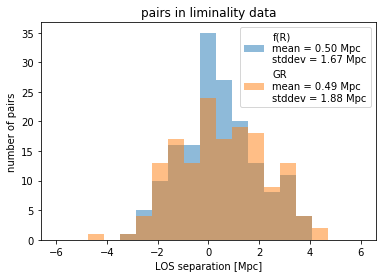

In [12]:
x = los_delta_pos_FR/hubble
a = plt.hist(x, bins=np.linspace(-6,6,20), alpha=0.5, label='f(R)\nmean = {:.2f} Mpc \nstddev = {:.2f} Mpc'.format(x.mean(), x.std()))

x = los_delta_pos_GR/hubble
a = plt.hist(x, bins=np.linspace(-6,6,20), alpha=0.5, label='GR\nmean = {:.2f} Mpc \nstddev = {:.2f} Mpc'.format(x.mean(), x.std()))

plt.xlabel('LOS separation [Mpc]')
plt.ylabel('number of pairs')
plt.title('pairs in liminality data')
plt.legend()
scipy.stats.ks_2samp(los_delta_pos_FR/hubble ,los_delta_pos_GR/hubble)

Ks_2sampResult(statistic=0.04387379087977894, pvalue=0.99720971277587578)

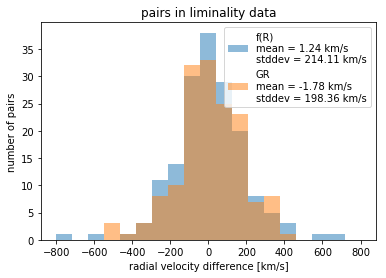

In [13]:
x = los_delta_vel_FR
a = plt.hist(x, bins=np.linspace(-800,800,20), alpha=0.5, label='f(R)\nmean = {:.2f} km/s \nstddev = {:.2f} km/s'.format(x.mean(), x.std()))

x = los_delta_vel_GR
a = plt.hist(x, bins=np.linspace(-800,800,20), alpha=0.5, label='GR\nmean = {:.2f} km/s \nstddev = {:.2f} km/s'.format(x.mean(), x.std()))
plt.xlabel('radial velocity difference [km/s]')
plt.ylabel('number of pairs')
plt.title('pairs in liminality data')
plt.legend()
scipy.stats.ks_2samp(los_delta_vel_FR ,los_delta_vel_GR)

## Scatter plots for the kinematic conditions of isolated pairs

5.12033411878 23.3587176861


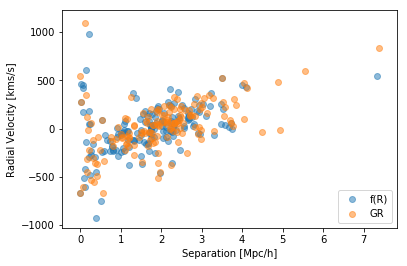

In [14]:
plt.scatter(norm_relative_pos_FR, radial_vel_FR, alpha=0.5, label="f(R)")
plt.scatter(norm_relative_pos_GR, radial_vel_GR, alpha=0.5, label="GR")
plt.xlabel("Separation [Mpc/h]")
plt.ylabel("Radial Velocity [kms/s]")
plt.legend()
print(radial_vel_FR.mean(), radial_vel_GR.mean())

mean negative radial velocity FR -186.838370102
mean negative radial velocity GR -190.754323266


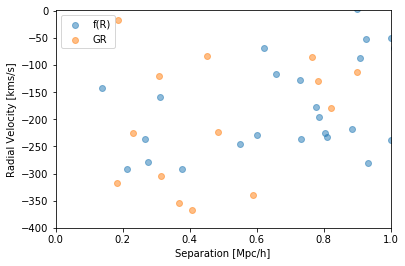

In [15]:
plt.scatter(norm_relative_pos_FR, radial_vel_FR, alpha=0.5, label="f(R)")
plt.scatter(norm_relative_pos_GR, radial_vel_GR, alpha=0.5, label="GR")
plt.xlim([0,1.0])
plt.ylim([-400.0,1.0])
plt.xlabel("Separation [Mpc/h]")
plt.ylabel("Radial Velocity [kms/s]")
plt.legend()
print("mean negative radial velocity FR",radial_vel_FR[radial_vel_FR<0]. mean())
print("mean negative radial velocity GR", radial_vel_GR[radial_vel_GR<0].mean())

5.12033411878 23.3587176861


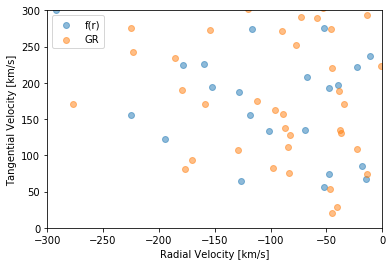

In [16]:
plt.scatter(radial_vel_FR, tangential_vel_FR, alpha=0.5, label='f(r)')
plt.scatter(radial_vel_GR, tangential_vel_GR, alpha=0.5, label='GR')
plt.xlim([-300.0,0.0])
plt.ylim([0,300])
plt.xlabel("Radial Velocity [km/s]")
plt.ylabel("Tangential Velocity [km/s]")
plt.legend()
print(radial_vel_FR.mean(), radial_vel_GR.mean())

## Distributions for the Isolated Pair sample

Ks_2sampResult(statistic=0.057961001074773533, pvalue=0.94299555393650425)

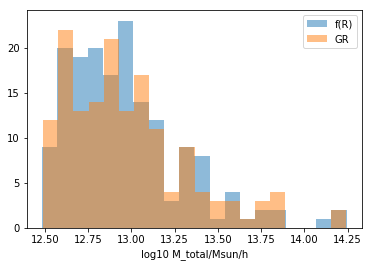

In [17]:
a = plt.hist(np.log10(mvir_A_FR + mvir_B_FR), bins=20, alpha=0.5, label='f(R)')
a = plt.hist(np.log10(mvir_A_GR + mvir_B_GR), bins=20, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("log10 M_total/Msun/h")
scipy.stats.ks_2samp(np.log10(mvir_A_FR + mvir_B_FR), np.log10(mvir_A_GR + mvir_B_GR))

Ks_2sampResult(statistic=0.13296483955166594, pvalue=0.10607963473327213)

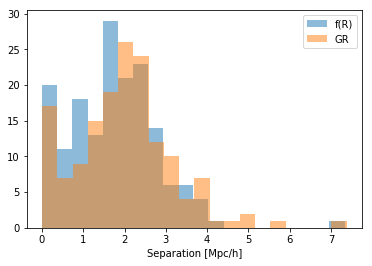

In [18]:
a = plt.hist(norm_relative_pos_FR, bins=20, alpha=0.5, label='f(R)')
a = plt.hist(norm_relative_pos_GR, bins=20, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("Separation [Mpc/h]")
scipy.stats.ks_2samp(norm_relative_pos_FR,norm_relative_pos_GR)

Ks_2sampResult(statistic=0.080608014739751321, pvalue=0.65314169627902463)

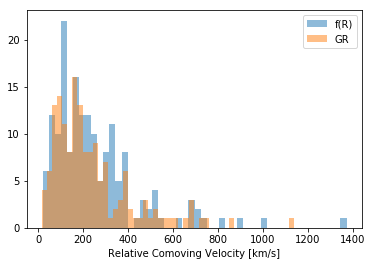

In [19]:
a = plt.hist(norm_relative_vel_FR, bins=50, alpha=0.5, label='f(R)')
a = plt.hist(norm_relative_vel_GR, bins=50, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("Relative Comoving Velocity [km/s]")
scipy.stats.ks_2samp(norm_relative_vel_FR,norm_relative_vel_GR)

249.878064498


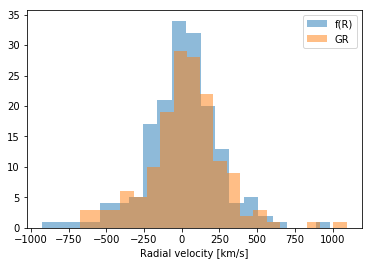

In [48]:
a = plt.hist(radial_vel_FR, bins=20, alpha=0.5, label='f(R)')
a = plt.hist(radial_vel_GR, bins=20, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("Radial velocity [km/s]")
scipy.stats.ks_2samp(radial_vel_FR,radial_vel_GR)
print(radial_vel_FR.std())

[ 221.0873176   322.48403759  423.9818623 ]
[ 132.73993589  192.21929841  272.03478179]


Ks_2sampResult(statistic=0.26412559496391835, pvalue=1.8564282940023506e-05)

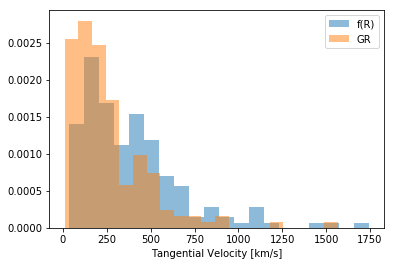

In [21]:
a = plt.hist(tangential_vel_FR, bins=20, alpha=0.5, normed=True, label='f(R)')
a = plt.hist(tangential_vel_GR, bins=20, alpha=0.5, normed=True, label='GR')
plt.legend()
plt.xlabel("Tangential Velocity [km/s]")
print(np.percentile(tangential_vel_FR, q=[34,50,66]))
print(np.percentile(tangential_vel_GR, q=[34,50,66]))
scipy.stats.ks_2samp(tangential_vel_FR,tangential_vel_GR)

0.446478873239
0.475424409145


Ks_2sampResult(statistic=0.056540764624596951, pvalue=0.95333448267941934)

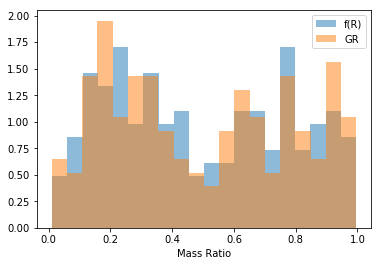

In [22]:
mass_ratio_FR = max_mass_FR = np.min([mvir_A_FR, mvir_B_FR],axis=0)/np.max([mvir_A_FR, mvir_B_FR],axis=0)
mass_ratio_GR = max_mass_GR = np.min([mvir_A_GR, mvir_B_GR],axis=0)/np.max([mvir_A_GR, mvir_B_GR],axis=0)

a = plt.hist(mass_ratio_FR, bins=20, alpha=0.5, normed=True, label='f(R)')
a = plt.hist(mass_ratio_GR, bins=20, alpha=0.5, normed=True, label='GR')
plt.legend()
plt.xlabel("Mass Ratio")
print(np.percentile(mass_ratio_FR, q=50))
print(np.percentile(mass_ratio_GR, q=50))
scipy.stats.ks_2samp(mass_ratio_FR,mass_ratio_GR)

## Distributions for the Local Group sample (constraints on the radial velocity)

In [23]:
ii_FR = (radial_vel_FR<-100.0)&(radial_vel_FR>-120)
ii_GR = (radial_vel_GR<-100.0)&(radial_vel_GR>-120)
print(np.count_nonzero(ii_FR), np.count_nonzero(ii_GR))

6 3


median separation FR 1.38261130946
median separation GR 1.73596987794


Ks_2sampResult(statistic=0.33333333333333337, pvalue=0.93496576852022273)

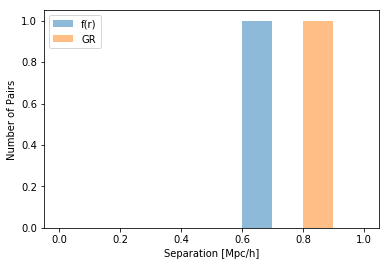

In [24]:
a = plt.hist(norm_relative_pos_FR[ii_FR], bins=np.linspace(0.0,1.0,11), alpha=0.5, label='f(r)')
a = plt.hist(norm_relative_pos_GR[ii_GR], bins=np.linspace(0.0,1.0,11), alpha=0.5, label='GR')
plt.xlabel('Separation [Mpc/h]')
plt.ylabel('Number of Pairs')
plt.legend()

print('median separation FR', np.percentile(norm_relative_pos_FR[ii_FR],q=50))
print('median separation GR', np.percentile(norm_relative_pos_GR[ii_GR],q=50))
scipy.stats.ks_2samp(norm_relative_pos_FR[ii_FR],norm_relative_pos_GR[ii_GR])

median log10 total mass FR [ 12.59993489  12.65209902  12.78578837]
median log10 total mass GR [ 12.7899648   12.87494544  13.00711675]


Ks_2sampResult(statistic=0.33333333333333337, pvalue=0.93496576852022273)

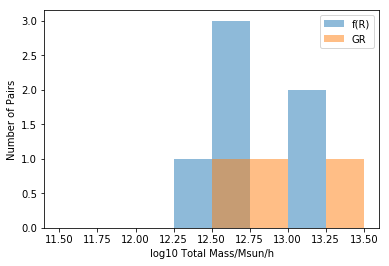

In [25]:
a = plt.hist(np.log10(mvir_A_FR[ii_FR]+mvir_B_FR[ii_FR]), bins=np.linspace(11.5,13.5,9), alpha=0.5, label='f(R)')
a = plt.hist(np.log10(mvir_A_GR[ii_GR]+mvir_B_GR[ii_GR]), bins=np.linspace(11.5,13.5,9), alpha=0.5, label='GR')
plt.xlabel('log10 Total Mass/Msun/h')
plt.ylabel('Number of Pairs')
plt.legend()
print('median log10 total mass FR', np.percentile(np.log10(mvir_A_FR[ii_FR]+mvir_B_FR[ii_FR]),q=[34,50,66]))
print('median log10 total mass GR', np.percentile(np.log10(mvir_A_GR[ii_GR]+mvir_B_GR[ii_GR]),q=[34,50,66]))
scipy.stats.ks_2samp(np.log10(mvir_A_FR[ii_FR]+mvir_B_FR[ii_FR]), np.log10(mvir_A_GR[ii_GR]+mvir_B_GR[ii_GR]))

median vtan FR [ 238.30520244  336.61010469  401.04618672]
median vtan GR [ 269.96295047  314.60465223  348.35207571]


Ks_2sampResult(statistic=0.33333333333333331, pvalue=0.93496576852022273)

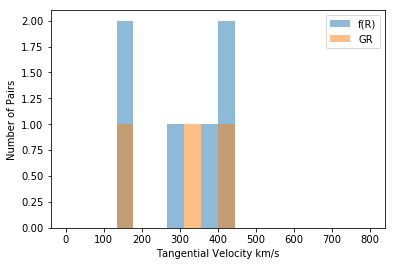

In [26]:
a = plt.hist(tangential_vel_FR[ii_FR], bins=np.linspace(0,800,19), alpha=0.5, label='f(R)')
a = plt.hist(tangential_vel_GR[ii_GR], bins=np.linspace(0,800,19), alpha=0.5, label='GR')
plt.xlabel('Tangential Velocity km/s')
plt.ylabel('Number of Pairs')
plt.legend()
print('median vtan FR', np.percentile(tangential_vel_FR[ii_FR], q=[34,50,66]))
print('median vtan GR', np.percentile(tangential_vel_GR[ii_GR], q=[34,50,66]))
scipy.stats.ks_2samp(tangential_vel_FR[ii_FR],tangential_vel_GR[ii_GR])

median mass ratio FR [ 0.65728927  0.71475381  0.76608454]
median mass ratio GR [ 0.44495565  0.51981206  0.55148255]


Ks_2sampResult(statistic=0.66666666666666674, pvalue=0.19836722181697544)

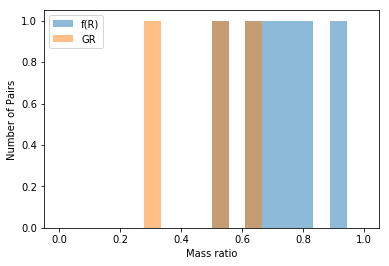

In [27]:
a = plt.hist(mass_ratio_FR[ii_FR], bins=np.linspace(0,1.0,19), alpha=0.5, label='f(R)')
a = plt.hist(mass_ratio_GR[ii_GR], bins=np.linspace(0,1.0,19), alpha=0.5, label='GR')
plt.xlabel('Mass ratio')
plt.ylabel('Number of Pairs')
plt.legend()
print('median mass ratio FR', np.percentile(mass_ratio_FR[ii_FR], q=[34,50,66]))
print('median mass ratio GR', np.percentile(mass_ratio_GR[ii_GR], q=[34,50,66]))
scipy.stats.ks_2samp(mass_ratio_FR[ii_FR],mass_ratio_GR[ii_GR])

## Conclusions

* Isolated Pairs can be differentiated by its tangential relative velocity. It is higher in $f(R)$ ($73$ km/s) than in $GR$ ($52$ km/s).
* However, Local Group Pairs have the same kinematics (i.e. separation, total mass and tangential velocity) in $f(R)$ and $GR$ simulations. 
* Our predicted tangential velocity for Local Group Pairs ($165\pm 15$ km/s) matches perfectly Salomon et al. 2016 http://adsabs.harvard.edu/abs/2016MNRAS.456.4432S, and contradicts Sohn et al. 2012 http://adsabs.harvard.edu/abs/2012ApJ...753....7S.
* We don't agree with previous numerical studies (http://adsabs.harvard.edu/abs/2017MNRAS.466.4813C) that claim:
    - A difference in radial/tangential velocities for Local Group Pairs.  
    - A number density of Local Group pairs $~30$ times lower than the one we find.  
**The biggest difference is that their simulation has a mass resolution 64 times lower. **

# Samples under observational conditions

median delta_v_radial 10.224999999999987 sigma 130.01527999999996


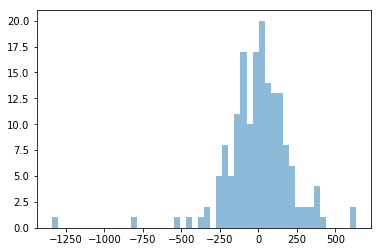

In [28]:
a = plt.hist(los_delta_vel_FR, bins=50, alpha=0.5, label='obs')
p = np.percentile(los_delta_vel_FR, q=[34,50,66])
print('median delta_v_radial {} sigma {}'.format(p[1], p[2]-p[0]))

median delta_d_radial 0.3640099999999986 sigma 1.0661870000000029


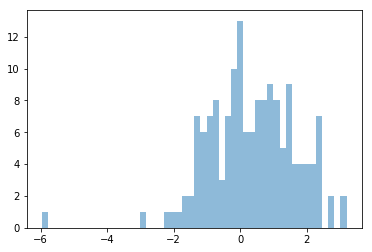

In [29]:
a = plt.hist((los_delta_pos_GR), bins=50, alpha=0.5, label='obs')
p = np.percentile(los_delta_pos_GR, q=[34,50,66])
print('median delta_d_radial {} sigma {}'.format(p[1], p[2]-p[0]))

median delta_v_radial 15.625000000000053 sigma 119.47130000000053


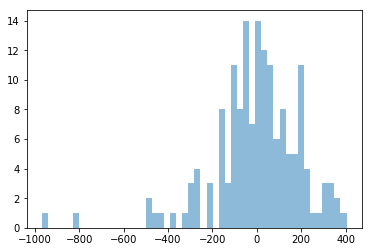

In [30]:
a = plt.hist(los_delta_vel_GR, bins=50, alpha=0.5, label='obs')
p = np.percentile(los_delta_vel_GR, q=[34,50,66])
print('median delta_v_radial {} sigma {}'.format(p[1], p[2]-p[0]))

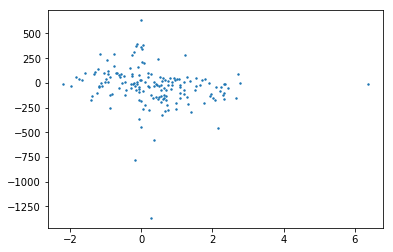

In [31]:
plt.scatter(relative_pos_FR[:,2], relative_vel_FR[:,2], s=2.0)

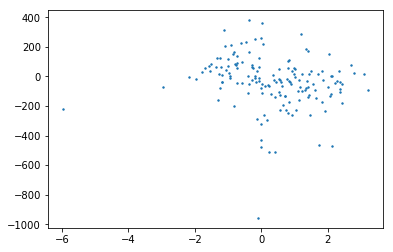

In [32]:
plt.scatter(relative_pos_GR[:,2], relative_vel_GR[:,2], s=2.0)

270.644013438
226.73308895
median mass ratio FR [  47.0112   85.92    134.2624]
median mass ratio FR [  52.263   76.1    124.001]


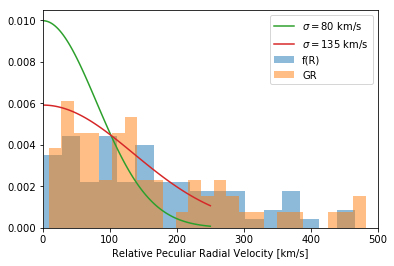

In [79]:
iiFR = sky_distance_FR<1.0/hubble
iiGR = sky_distance_GR<1.0/hubble
a = plt.hist(np.fabs(corrected_los_delta_vel_FR[iiFR]), bins=50, alpha=0.5, label='f(R)', normed=True)
a = plt.hist(np.fabs(corrected_los_delta_vel_GR[iiGR]), bins=50, alpha=0.5, label='GR', normed=True)
print(corrected_los_delta_vel_FR[iiFR].std())
print(corrected_los_delta_vel_GR[iiGR].std())

plt.xlabel("Relative Peculiar Radial Velocity [km/s]")
scipy.stats.ks_2samp(np.fabs(corrected_los_delta_vel_FR),np.fabs(corrected_los_delta_vel_GR))
print('median mass ratio FR', np.percentile(np.fabs(corrected_los_delta_vel_FR), q=[34,50,66]))
print('median mass ratio FR', np.percentile(np.fabs(corrected_los_delta_vel_GR), q=[34,50,66]))

sigma=80.0
x = np.linspace(0,250,100)
y = 2.0*(1.0/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5*(x/sigma)**2)
plt.plot(x,y, label="$\sigma=80$ km/s")

sigma=135.0
x = np.linspace(0,250,100)
y = 2.0*(1.0/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5*(x/sigma)**2)
plt.plot(x,y, label="$\sigma=135$ km/s")
plt.xlim([0,500])
plt.legend()


In [ ]:
a = plt.hist(np.fabs(corrected_los_delta_vel_FR), bins=50, alpha=0.5, label='f(R)')
a = plt.hist(np.fabs(corrected_los_delta_vel_GR), bins=50, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("Relative Peculiar Radial Velocity [km/s]")
scipy.stats.ks_2samp(np.fabs(corrected_los_delta_vel_FR),np.fabs(corrected_los_delta_vel_GR))
print('median mass ratio FR', np.percentile(np.fabs(corrected_los_delta_vel_FR), q=[34,50,66]))
print('median mass ratio FR', np.percentile(np.fabs(corrected_los_delta_vel_GR), q=[34,50,66]))
plt.xlim()

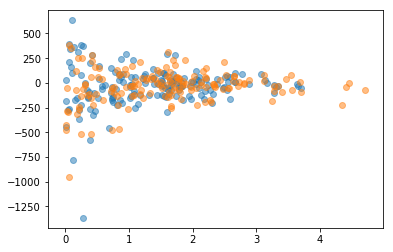

In [34]:
plt.scatter(sky_distance_FR, corrected_los_delta_vel_FR, alpha=0.5)
plt.scatter(sky_distance_GR, corrected_los_delta_vel_GR, alpha=0.5)

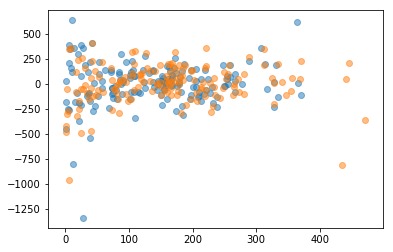

In [35]:
plt.scatter(sky_distance_FR*100, los_delta_vel_FR, alpha=0.5)
plt.scatter(sky_distance_GR*100, los_delta_vel_GR, alpha=0.5)

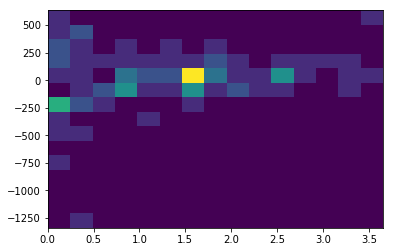

In [36]:
a = plt.hist2d(sky_distance_FR[mass_ratio_FR<0.5], los_delta_vel_FR[mass_ratio_FR<0.5], bins=15)

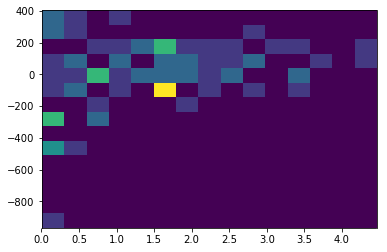

In [37]:
a = plt.hist2d(sky_distance_GR[mass_ratio_GR<0.5], los_delta_vel_GR[mass_ratio_GR<0.5],bins=15)

In [38]:
FR_select = (sky_distance_FR<0.5)
GR_select = (sky_distance_GR<0.5)
print(scipy.stats.ks_2samp(los_delta_vel_FR[FR_select],los_delta_vel_GR[GR_select]))

FR_select = (mass_ratio_FR<0.99)&(los_delta_vel_FR<100)
GR_select = (mass_ratio_GR<0.99)&(los_delta_vel_GR<100)
print(scipy.stats.ks_2samp(sky_distance_FR[FR_select],sky_distance_GR[GR_select]))

Ks_2sampResult(statistic=0.15238095238095239, pvalue=0.81498043639734097)
Ks_2sampResult(statistic=0.071929689306915345, pvalue=0.92057464479830042)


Ks_2sampResult(statistic=0.17344262295081969, pvalue=0.34801250380117527)

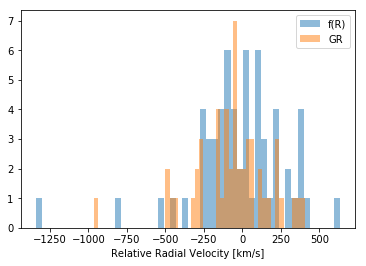

In [39]:
a = plt.hist(los_delta_vel_FR[sky_distance_FR<1.0], bins=50, alpha=0.5, label='f(R)')
a = plt.hist(los_delta_vel_GR[sky_distance_GR<1.0], bins=50, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("Relative Radial Velocity [km/s]")
scipy.stats.ks_2samp(los_delta_vel_FR[sky_distance_FR<1.0],los_delta_vel_GR[sky_distance_GR<1.0])

Ks_2sampResult(statistic=0.099646860125902015, pvalue=0.38165065444742247)

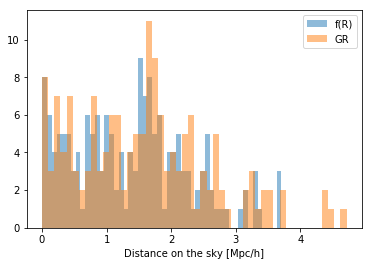

In [40]:
a = plt.hist(sky_distance_FR, bins=50, alpha=0.5, label='f(R)')
a = plt.hist(sky_distance_GR, bins=50, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("Distance on the sky [Mpc/h]")
scipy.stats.ks_2samp(sky_distance_FR,sky_distance_GR)

# Machine learning

Try to use random forets, support vector machine and gaussian process to distinguish between the two data sets

In [41]:
FR_data = np.array([sky_distance_FR/sky_distance_FR.std(), los_delta_vel_FR/los_delta_vel_FR.std(), mass_ratio_FR])
FR_data = FR_data.T
GR_data = np.array([sky_distance_GR/sky_distance_GR.std(), los_delta_vel_GR/los_delta_vel_GR.std(), mass_ratio_GR])
GR_data = GR_data.T

n_FR = len(FR_data)
n_GR = len(GR_data)
print(np.shape(FR_data[:,0]))
Y = np.zeros(n_FR+n_GR)
Y[0:n_FR] = 1.0
X = np.concatenate((FR_data, GR_data), axis=0)
print(np.shape(X))


(167,)
(323, 3)


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO

In [43]:
for i in range(10):
    clf = RandomForestClassifier(n_estimators=500, max_depth=10, criterion='entropy')
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
    clf.fit(X_train, Y_train)
    Y_predict = clf.predict(X_test)
    n_good = np.count_nonzero(Y_predict==Y_test)
    n_all = len(Y_test)
    print(n_good, n_all, n_good/n_all)

33 81 0.4074074074074074
37 81 0.4567901234567901
32 81 0.3950617283950617
29 81 0.35802469135802467
30 81 0.37037037037037035
32 81 0.3950617283950617
34 81 0.41975308641975306
35 81 0.43209876543209874
27 81 0.3333333333333333
24 81 0.2962962962962963


In [44]:
from sklearn.svm import SVC

In [45]:
for i in range(10):
    clf = SVC()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
    clf.fit(X_train, Y_train) 
    Y_predict = clf.predict(X_test)
    n_good = np.count_nonzero(Y_predict==Y_test)
    n_all = len(Y_test)
    print(n_good, n_all, n_good/n_all)

34 81 0.41975308641975306
40 81 0.49382716049382713
32 81 0.3950617283950617
38 81 0.4691358024691358
35 81 0.43209876543209874
36 81 0.4444444444444444
39 81 0.48148148148148145
34 81 0.41975308641975306
42 81 0.5185185185185185
37 81 0.4567901234567901


In [46]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [47]:
for i in range(10):
    clf =  GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
    clf.fit(X_train, Y_train) 
    Y_predict = clf.predict(X_test)
    n_good = np.count_nonzero(Y_predict==Y_test)
    n_all = len(Y_test)
    print(n_good, n_all, n_good/n_all)


41 81 0.5061728395061729
44 81 0.5432098765432098
42 81 0.5185185185185185
33 81 0.4074074074074074
44 81 0.5432098765432098
38 81 0.4691358024691358
34 81 0.41975308641975306
43 81 0.5308641975308642
45 81 0.5555555555555556
45 81 0.5555555555555556
